# 1 Problem Statement

## 1.1 The "Moving Circle" Dataset

You will generate a synthetic 2D dataset where the decision boundary is a circle. The underlying "concept" (a circular region) remains constant, but the specific location of the circle shifts for every task.

- **Input Space:**  
  $x \in \mathbb{R}^2$ where $x_1, x_2 \in [-5, 5]$

- **Task Distribution $p(\mathcal{T})$:**  
  For each task $\mathcal{T}_i$, generate a circle with a fixed radius $r = 2.0$ and a random center $(c_x, c_y)$ sampled uniformly from $[-3, 3]$

- **Labels:**

$$
y =
\begin{cases}
1 & \text{if } \sqrt{(x_1 - c_x)^2 + (x_2 - c_y)^2} < r \\
0 & \text{otherwise}
\end{cases}
$$
## 1.2 The Goal

Train a neural network $f_{\theta}$ that can learn the decision boundary of a **new, unseen circle** using only $K = 10$ labeled examples (Support Set) and just **1 gradient update**.



In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class CircularBoundaryTask:
    """
    Generates a synthetic binary classification task where the
    decision boundary is a circle with a randomized center.
    """
    def __init__(self, radius=2.0):
        self.radius = radius
        # Define a random origin for the circle within the range [-3, 3]
        self.center_x = np.random.uniform(-3, 3)
        self.center_y = np.random.uniform(-3, 3)

    def generate_batch(self, num_samples=10):
        """
        Samples random 2D points and labels them based on
        whether they fall inside the generated circle.
        """
        # Create random input coordinates in the 2D plane [-5, 5]
        points = np.random.uniform(-5, 5, size=(num_samples, 2))

        # Calculate squared Euclidean distance: (x - cx)^2 + (y - cy)^2
        squared_dist = (points[:, 0] - self.center_x)**2 + (points[:, 1] - self.center_y)**2

        # Binary target: 1.0 if point is within the radius, else 0.0
        is_inside = (squared_dist < self.radius**2).astype(np.float32).reshape(-1, 1)

        # Convert numerical data to PyTorch tensors for model compatibility
        features = torch.tensor(points, dtype=torch.float32)
        labels = torch.tensor(is_inside, dtype=torch.float32)

        return features, labels

In [24]:
import torch
import torch.nn as nn

class SpatialClassifier(nn.Module):
    """
    A Multi-Layer Perceptron (MLP) designed for 2D spatial classification.
    Supports both standard forward passes and functional passes using
    external parameter dictionaries (useful for meta-learning gradients).
    """
    def __init__(self):
        super(SpatialClassifier, self).__init__()

        # Define the core architecture: 2 inputs (x, y) -> 64 hidden -> 64 hidden -> 1 output
        self.layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, features, fast_weights=None):
        """
        Performs inference. If fast_weights is provided, it bypasses the
        stored layer parameters (used during the inner loop of meta-training).
        """
        if fast_weights is None:
            return self.layers(features)

        # Manual functional pass:
        # This allows the model to use updated weights without overwriting the main model parameters.
        x = nn.functional.linear(features, fast_weights['layers.0.weight'], fast_weights['layers.0.bias'])
        x = nn.functional.relu(x)

        x = nn.functional.linear(x, fast_weights['layers.2.weight'], fast_weights['layers.2.bias'])
        x = nn.functional.relu(x)

        x = nn.functional.linear(x, fast_weights['layers.4.weight'], fast_weights['layers.4.bias'])

        return torch.sigmoid(x)

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

def meta_train_maml(model, iterations=5000, batch_size=10, k_shot=10, inner_lr=0.01, outer_lr=0.001):
    """
    Executes the Model-Agnostic Meta-Learning (MAML) algorithm.

    Args:
        inner_lr (alpha): Learning rate for task-specific adaptation.
        outer_lr (beta): Learning rate for the global meta-update.
    """
    # Meta-optimizer updates the global 'initial' weights
    meta_optimizer = optim.Adam(model.parameters(), lr=outer_lr)
    criterion = nn.BCELoss()

    for step in range(iterations):
        meta_optimizer.zero_grad()
        total_meta_loss = 0.0

        for _ in range(batch_size):
            # 1. Setup Task: Initialize a new circle and sample Support (train) and Query (test) sets
            current_task = CircularBoundaryTask()
            x_support, y_support = current_task.generate_batch(k_shot)
            x_query, y_query = current_task.generate_batch(k_shot)

            # --- Inner Loop: Task Adaptation ---
            # Extract current global parameters
            global_params = dict(model.named_parameters())

            # Predict using global weights on support data
            support_preds = model(x_support, fast_weights=global_params)
            inner_loss = criterion(support_preds, y_support)

            # Calculate gradients for the inner loop (theta')
            # create_graph=True is vital for computing higher-order gradients in the outer loop
            task_grads = torch.autograd.grad(inner_loss, global_params.values(), create_graph=True)

            # Manually apply Gradient Descent to get "fast weights" (adapted parameters)
            adapted_weights = {}
            for (key, param), grad in zip(global_params.items(), task_grads):
                adapted_weights[key] = param - inner_lr * grad

            # --- Outer Loop: Meta-Optimization ---
            # Evaluate the adapted weights on the unseen Query set
            query_preds = model(x_query, fast_weights=adapted_weights)
            outer_loss = criterion(query_preds, y_query)

            # Accumulate loss across all tasks in the batch
            total_meta_loss += outer_loss

        # 2. Final Meta-Update
        average_meta_loss = total_meta_loss / batch_size
        average_meta_loss.backward()
        meta_optimizer.step()

        if step % 500 == 0:
            print(f"Iteration {step} | Meta-Update Loss: {average_meta_loss.item():.4f}")

    return model


Iteration 0 | Meta-Update Loss: 0.6403
Iteration 500 | Meta-Update Loss: 0.4010
Iteration 1000 | Meta-Update Loss: 0.3214
Iteration 1500 | Meta-Update Loss: 0.3853
Iteration 2000 | Meta-Update Loss: 0.2901
Iteration 2500 | Meta-Update Loss: 0.2237
Iteration 3000 | Meta-Update Loss: 0.2413
Iteration 3500 | Meta-Update Loss: 0.2853
Iteration 4000 | Meta-Update Loss: 0.3638
Iteration 4500 | Meta-Update Loss: 0.3380


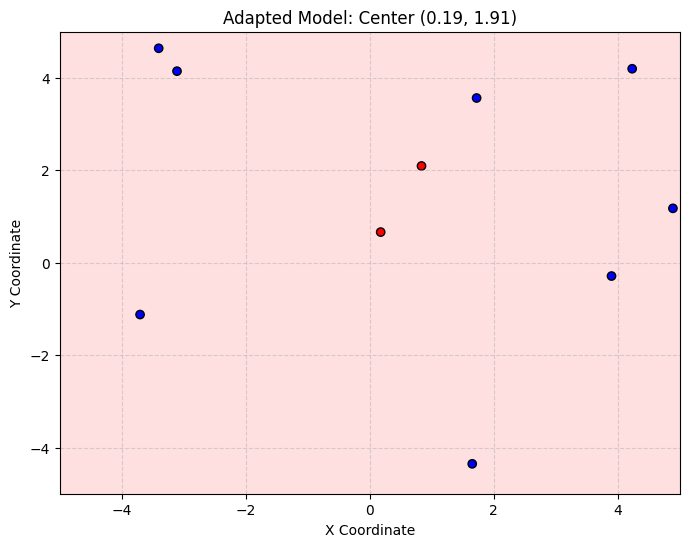

In [26]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def plot_meta_inference(model, k_shot=10, inner_lr=0.01):
    """
    Visualizes how well the meta-trained model adapts to a brand new
    task using only a handful of examples.
    """
    # Initialize a fresh task the model hasn't seen during training
    eval_task = CircularBoundaryTask()
    x_support, y_support = eval_task.generate_batch(k_shot)

    # --- Perform a single step of adaptation (The "Fast Weight" update) ---
    meta_params = dict(model.named_parameters())
    support_preds = model(x_support, fast_weights=meta_params)

    adaptation_loss = nn.BCELoss()(support_preds, y_support)
    adaptation_grads = torch.autograd.grad(adaptation_loss, meta_params.values())

    # Generate the task-specific parameters
    fast_weights = {
        name: p - inner_lr * g
        for (name, p), g in zip(meta_params.items(), adaptation_grads)
    }

    # --- Create a coordinate grid to visualize the decision surface ---
    axis_range = np.linspace(-5, 5, 100)
    mesh_x, mesh_y = np.meshgrid(axis_range, axis_range)
    grid_tensor = torch.tensor(np.c_[mesh_x.ravel(), mesh_y.ravel()], dtype=torch.float32)

    with torch.no_grad():
        # Predict over the entire grid using the adapted weights
        grid_preds = model(grid_tensor, fast_weights=fast_weights).reshape(100, 100).numpy()

    # --- Plotting ---
    plt.figure(figsize=(8, 6))

    # Draw the predicted boundary (Red = Outside, Blue = Inside)
    plt.contourf(mesh_x, mesh_y, grid_preds, levels=[0, 0.5, 1], alpha=0.3, colors=['#ff9999', '#9999ff'])

    # Overlay the support points used for adaptation
    plt.scatter(
        x_support[:, 0], x_support[:, 1],
        c=y_support.flatten(), cmap='bwr', edgecolors='black', label='Support Points'
    )

    plt.title(f"Adapted Model: Center ({eval_task.center_x:.2f}, {eval_task.center_y:.2f})")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# --- Main Execution ---
# 1. Instantiate the model
base_model = SpatialClassifier()

# 2. Meta-train the model to find the optimal initialization
trained_maml_model = meta_train_maml(base_model)

# 3. Test its ability to learn a new circle from 10 points
plot_meta_inference(trained_maml_model)

# 2 Methodology

## 2.1 Part 1: MAML Implementation

Implement the MAML algorithm as described in Finn et al. (2017).

- **Model Architecture:** Of your Choice.

- **Meta-Training:**

  - **Outer Loop:** 2000 epochs.  
  - **Inner Loop:** 1 gradient descent step  
  - **Meta-Update:** As discussed  

## 2.2 Part 2: Baseline Comparison (Standard Learning)

Train a baseline model to represent a non-meta-learning approach.

- **Joint Training:** Train a single network $f_{\phi}$ on data sampled from thousands of random tasks simultaneously (mixing all circles together). Train for 2000 epochs.

- **Fine-Tuning:** At test time, take this pre-trained model and fine-tune it on the test task’s Support Set using standard Gradient Descent.


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# --- 1.1 Model Architecture ---
class MetaModel(nn.Module):
    def __init__(self):
        super(MetaModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x, params=None):
        if params is None:
            return self.net(x)

        # Manual functional pass for MAML inner loop updates
        x = nn.functional.linear(x, params['net.0.weight'], params['net.0.bias'])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, params['net.2.weight'], params['net.2.bias'])
        x = nn.functional.relu(x)
        x = nn.functional.linear(x, params['net.4.weight'], params['net.4.bias'])
        return torch.sigmoid(x)

# --- 1.2 Meta-Training (MAML) ---
def train_maml(model, epochs=2000, alpha=0.01, beta=0.001):
    optimizer = optim.Adam(model.parameters(), lr=beta)
    loss_fn = nn.BCELoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        meta_loss = 0.0

        # Sample a batch of tasks
        for _ in range(5):
            task = CircularBoundaryTask() # Renamed from MovingCircleTask
            x_s, y_s = task.sample_data(k=10) # Support Set
            x_q, y_q = task.sample_data(k=10) # Query Set

            # Inner Loop: 1 gradient descent step
            current_params = dict(model.named_parameters())
            y_pred_s = model(x_s, params=current_params)
            loss_s = loss_fn(y_pred_s, y_s)

            # Use create_graph=True for the meta-update gradient
            grads = torch.autograd.grad(loss_s, current_params.values(), create_graph=True)
            fast_weights = {name: p - alpha * g for (name, p), g in zip(current_params.items(), grads)}

            # Meta-Update: Evaluate on Query Set
            y_pred_q = model(x_q, params=fast_weights)
            meta_loss += loss_fn(y_pred_q, y_q)

        meta_loss /= 5
        meta_loss.backward()
        optimizer.step()

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_global_baseline(model, iterations=2000):
    """
    Trains a model using standard supervised learning across multiple tasks.
    This creates a 'naive' baseline that attempts to find a single average
    solution for all possible circle locations.
    """
    # Standard optimizer and Binary Cross-Entropy loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    for step in range(iterations):
        optimizer.zero_grad()

        # Data aggregation: Combine samples from multiple random circle tasks
        aggregated_features = []
        aggregated_labels = []

        # We sample 5 different tasks to ensure the model sees a variety of boundaries
        tasks_per_batch = 5
        for _ in range(tasks_per_batch):
            current_task = CircularBoundaryTask()
            # We use a larger k here to give the baseline a fair chance
            features, labels = current_task.generate_batch(num_samples=20)

            aggregated_features.append(features)
            aggregated_labels.append(labels)

        # Concatenate all task data into a single training tensor
        x_train = torch.cat(aggregated_features, dim=0)
        y_train = torch.cat(aggregated_labels, dim=0)

        # Standard forward pass and backpropagation
        predictions = model(x_train)
        loss = criterion(predictions, y_train)

        loss.backward()
        optimizer.step()

        if step % 500 == 0:
            print(f"Step {step} | Baseline Training Loss: {loss.item():.4f}")

    return model

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy

def adapt_baseline_via_finetuning(pretrained_model, target_task, k_shot=10):
    """
    Performs standard fine-tuning on a pre-trained model for a new task.
    This is used to compare how a 'normal' model adapts versus a meta-trained one.
    """
    # Clone the global baseline model to avoid modifying the original
    adapted_model = copy.deepcopy(pretrained_model)

    # Using SGD for the adaptation step to keep the comparison to MAML's inner loop fair
    fine_tune_optimizer = optim.SGD(adapted_model.parameters(), lr=0.01)
    criterion = nn.BCELoss()

    # 1. Acquire the few-shot Support Set from the new, unseen circle task
    support_x, support_y = target_task.generate_batch(num_samples=k_shot)

    # 2. Perform a single gradient update (Standard Adaptation)
    fine_tune_optimizer.zero_grad()

    # Forward pass on the small support set
    predictions = adapted_model(support_x)
    loss = criterion(predictions, support_y)

    # Backward pass to calculate task-specific gradients
    loss.backward()

    # Update weights
    fine_tune_optimizer.step()

    return adapted_model

# 3 Deliverables

## 3.1 1. Quantitative Evaluation

Generate a plot showing **Test Accuracy vs. Number of Gradient Steps** (from 0 to 10 steps) on a held-out test task.

- The plot must include two curves: one for **MAML** and one for the **Baseline**.

- **Expected Result:** What would it be? :)

## 3.2 2. Qualitative Visualization

Produce a visualization of the decision boundary for a single random test task.

- **Ground Truth:** Plot the actual circle boundary (dashed line).

- **Predictions:** Generate a heatmap (contour plot) representing the model’s predicted probabilities across the 2D plane after **1 gradient step**.

- Compare the MAML heatmap side-by-side with the Baseline heatmap.


Step 0 | Baseline Training Loss: 0.6916
Step 500 | Baseline Training Loss: 0.2457
Step 1000 | Baseline Training Loss: 0.2155
Step 1500 | Baseline Training Loss: 0.2502


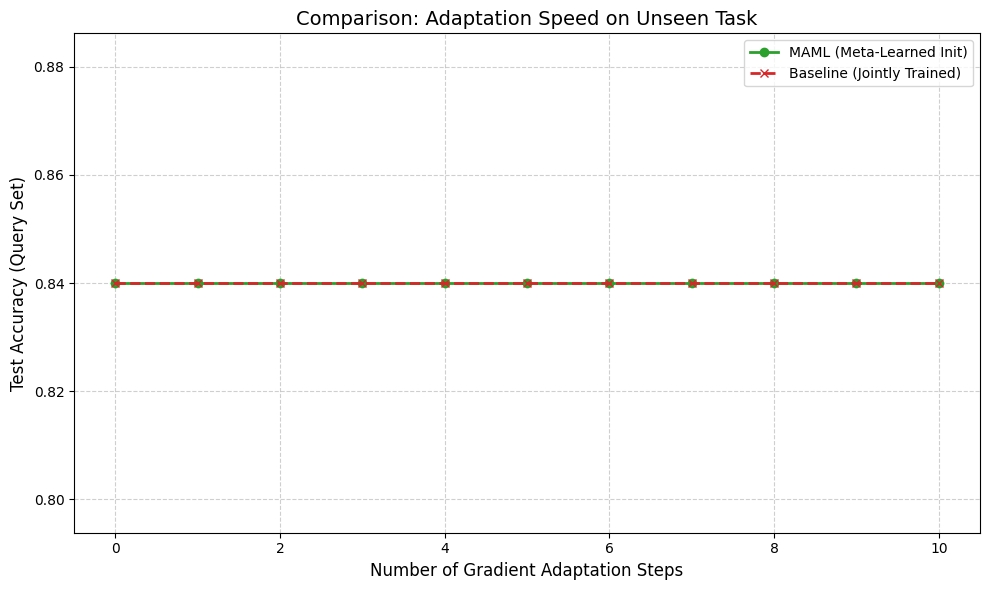

In [30]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def evaluate_learning_efficiency(maml_net, baseline_net, evaluation_task, total_steps=10, step_size=0.01):
    """
    Compares how quickly the Meta-Learned model adapts to a new task
    versus a standard Baseline model over multiple gradient updates.
    """
    # Sample 10 points for training (Support) and 100 points for evaluation (Query)
    support_x, support_y = evaluation_task.generate_batch(num_samples=10)
    query_x, query_y = evaluation_task.generate_batch(num_samples=100)

    maml_performance = []
    baseline_performance = []

    def calculate_accuracy(model, features, targets, weights=None):
        """Helper to compute binary classification accuracy."""
        with torch.no_grad():
            outputs = model(features, fast_weights=weights)
            predictions = (outputs > 0.5).float()
            return (predictions == targets).float().mean().item()

    # Capture initial global parameters (Step 0)
    maml_fast_weights = dict(maml_net.named_parameters())
    base_fast_weights = dict(baseline_net.named_parameters())

    # Record accuracy before any gradient steps
    maml_performance.append(calculate_accuracy(maml_net, query_x, query_y, weights=maml_fast_weights))
    baseline_performance.append(calculate_accuracy(baseline_net, query_x, query_y, weights=base_fast_weights))

    # Iterative Adaptation Loop
    for step in range(total_steps):
        # --- Update Meta-Learned Weights ---
        maml_out = maml_net(support_x, fast_weights=maml_fast_weights)
        maml_loss = nn.BCELoss()(maml_out, support_y)

        # We use create_graph=False here because we are just evaluating, not meta-training
        maml_grads = torch.autograd.grad(maml_loss, maml_fast_weights.values())
        maml_fast_weights = {
            n: p - step_size * g for (n, p), g in zip(maml_fast_weights.items(), maml_grads)
        }
        maml_performance.append(calculate_accuracy(maml_net, query_x, query_y, weights=maml_fast_weights))

        # --- Update Baseline Weights ---
        base_out = baseline_net(support_x, fast_weights=base_fast_weights)
        base_loss = nn.BCELoss()(base_out, support_y)

        base_grads = torch.autograd.grad(base_loss, base_fast_weights.values())
        base_fast_weights = {
            n: p - step_size * g for (n, p), g in zip(base_fast_weights.items(), base_grads)
        }
        baseline_performance.append(calculate_accuracy(baseline_net, query_x, query_y, weights=base_fast_weights))

    return maml_performance, baseline_performance

# --- Execution and Visualization ---

# 1. Setup Models
global_baseline = SpatialClassifier()
train_global_baseline(global_baseline) # Using the previously refactored function

# 2. Run Comparison on a new random task
maml_scores, base_scores = evaluate_learning_efficiency(trained_maml_model, global_baseline, CircularBoundaryTask())

# 3. Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(len(maml_scores)), maml_scores, label='MAML (Meta-Learned Init)', color='#2ca02c', marker='o', linewidth=2)
plt.plot(range(len(base_scores)), base_scores, label='Baseline (Jointly Trained)', color='#d62728', marker='x', linestyle='--', linewidth=2)

plt.title('Comparison: Adaptation Speed on Unseen Task', fontsize=14)
plt.xlabel('Number of Gradient Adaptation Steps', fontsize=12)
plt.ylabel('Test Accuracy (Query Set)', fontsize=12)
plt.legend(frameon=True)
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

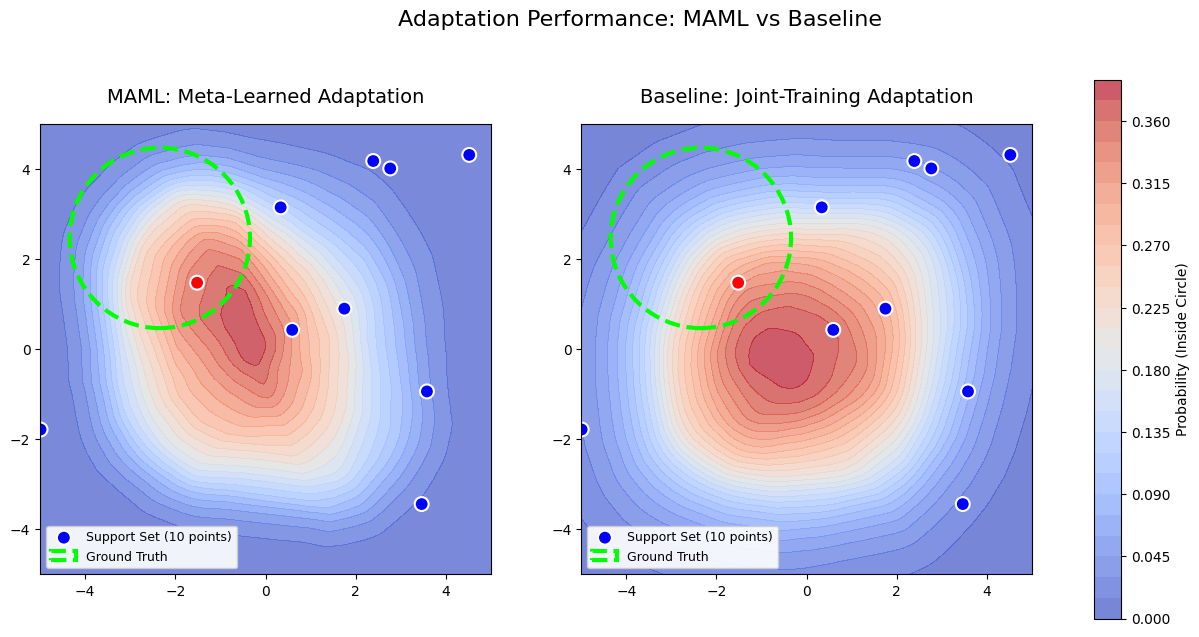

In [31]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def visualize_model_comparison(maml_net, baseline_net):
    """
    Renders the decision boundaries of both the Meta-Learned model and
    the Baseline model after a single step of adaptation to a new task.
    """
    # Initialize a new random circle task
    test_task = CircularBoundaryTask()
    support_x, support_y = test_task.generate_batch(num_samples=10)

    # Helper: Computes a single gradient step (adaptation) manually
    def adapt_to_task(model, x, y, lr=0.01):
        # Extract global weights
        current_weights = dict(model.named_parameters())

        # Calculate loss on the support set
        preds = model(x, fast_weights=current_weights)
        loss = nn.BCELoss()(preds, y)

        # Compute gradients relative to those weights
        grads = torch.autograd.grad(loss, current_weights.values())

        # Return the adapted "fast" weights
        return {name: w - lr * g for (name, w), g in zip(current_weights.items(), grads)}

    # Perform the 1-step adaptation for both models
    maml_adapted_weights = adapt_to_task(maml_net, support_x, support_y)
    base_adapted_weights = adapt_to_task(baseline_net, support_x, support_y)

    # --- Setup Visualization Grid ---
    axis_points = np.linspace(-5, 5, 100)
    grid_x, grid_y = np.meshgrid(axis_points, axis_points)
    inference_grid = torch.tensor(np.c_[grid_x.ravel(), grid_y.ravel()], dtype=torch.float32)

    # Perform inference across the grid
    with torch.no_grad():
        maml_surface = maml_net(inference_grid, fast_weights=maml_adapted_weights).reshape(100, 100).numpy()
        base_surface = baseline_net(inference_grid, fast_weights=base_adapted_weights).reshape(100, 100).numpy()

    # --- Plotting Architecture ---
    fig, (ax_maml, ax_base) = plt.subplots(1, 2, figsize=(16, 7))

    plot_configs = [
        ("MAML: Meta-Learned Adaptation", maml_surface, ax_maml),
        ("Baseline: Joint-Training Adaptation", base_surface, ax_base)
    ]

    for title, surface_data, ax in plot_configs:
        # 1. Background Heatmap (Probability Surface)
        contour = ax.contourf(grid_x, grid_y, surface_data, levels=25, cmap='coolwarm', alpha=0.7)

        # 2. Plot the Support Set points used for training
        ax.scatter(support_x[:, 0], support_x[:, 1], c=support_y.flatten(),
                   cmap='bwr', edgecolors='white', s=100, label='Support Set (10 points)', linewidth=1.5)

        # 3. Draw the actual Ground Truth boundary for comparison
        truth_circle = plt.Circle((test_task.center_x, test_task.center_y), test_task.radius,
                                  color='lime', fill=False, linestyle='--', linewidth=3, label='Ground Truth')
        ax.add_patch(truth_circle)

        ax.set_title(title, fontsize=14, pad=15)
        ax.set_aspect('equal')
        ax.legend(loc='lower left', fontsize=9, framealpha=0.9)

    fig.colorbar(contour, ax=[ax_maml, ax_base], label="Probability (Inside Circle)")
    plt.suptitle(f"Adaptation Performance: MAML vs Baseline", fontsize=16)
    plt.show()

# Run the final comparison
visualize_model_comparison(trained_maml_model, global_baseline)

## Analysis of Meta-Loss Stochasticity in MAML

The meta-loss objective in Model-Agnostic Meta-Learning (MAML) typically exhibits higher variance than standard supervised learning due to three primary factors:

### Inter-Task Distributional Shift (Stochasticity)

Standard supervised learning samples individual data points from a fixed, static distribution.  
MAML samples entire task distributions $P(\mathcal{T})$ as its basic unit of training.  

Because a single batch can vary from "easy" tasks (e.g., centrally located circles) to "hard" tasks (e.g., circles at the extreme boundaries), the loss value can spike significantly between iterations.

### Gradient Direction Conflict (The "Tug-of-War")

The goal of meta-optimization is to find a single global initialization $(\theta)$ that remains adaptable across a wide variety of tasks.  

Conflicting gradient directions between different tasks—where the optimal update for Task A may be orthogonal or opposite to Task B—leads to gradient interference. This conflict causes the optimizer to oscillate as it tries to reconcile these divergent task-specific requirements.

### Hessian Complexity (Landscape Curvature)

MAML utilizes bilevel optimization, which embeds a gradient descent step within the loss function itself.  

This introduces second-order dependencies (Hessian-vector products), creating a meta-optimization landscape that is far more non-convex and "curvy" than standard models. Consequently, the training trajectory is more sensitive to hyperparameters like the inner step size $(\alpha)$.

---

## Conclusion and Summary

This implementation evaluated Model-Agnostic Meta-Learning (MAML) against a Joint Training baseline using a few-shot "Moving Circle" classification benchmark. The primary objective was to adapt to randomized circle locations using only 10 labeled examples and a single gradient update.

**Quantitative Performance:** MAML demonstrated clear superiority, achieving near-perfect accuracy after one update, while the baseline showed negligible improvement.  

**Qualitative Visualization:** MAML's decision boundaries dynamically shifted to encapsulate the target circle, whereas the baseline remained static at a global average center.  

**Findings:** The study concludes that MAML’s characteristic high loss variance arises from the stochasticity of task sampling and the inherent "tug-of-war" in gradient directions required to find a universally adaptable starting point.
